In [1]:
## default libraries
from glob import glob
import numpy as np
import pandas as pd
import scipy as sp
import os, sys, logging
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import palettable.colorbrewer as cb
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statannotations import Annotator
import h5py as h5
# import ipywidgets as widgets
import pyro
import torch




#### My libraries
import pygwas.core as pygwas
import bshap.core as bshap
import pyquant.genopheno as pyquant
import snpmatch
from pygenome import genome
import pygenome.plotting as  genome_plotting


### Few settings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style="white", color_codes=True, font_scale = 1.25)
log = logging.getLogger(__name__)

### Global variables
context_colors = cb.qualitative.Set2_3.hex_colors
temp_color = {'T4': cb.sequential.Blues_6.hex_colors[3], "T16": cb.sequential.Oranges_6.hex_colors[3]}
geno_color = {'AA': cb.diverging.BrBG_6.hex_colors[4], 'BB': cb.diverging.BrBG_6.hex_colors[1], 'AB': cb.sequential.Greys_5.hex_colors[2]}

home_dir = "/users/rahul.pisupati/"
proj_dir = "/groups/nordborg/projects/"
# home_dir = "/vol/HOME/"
# proj_dir = "/projects/"

tair10 = genome.GenomeClass(home_dir +  "/TAiR10_ARABIDOPSIS/TAIR10_wholeGenome.fasta")
tair10.centro_start = np.array([14364752, 3602775, 12674550, 2919690, 11668616, 0, 0])
tair10.centro_end   = np.array([15750321, 3735247, 13674767, 4011692, 12082583, 0, 0])
tair10.centro_mid = ((tair10.centro_start + tair10.centro_end)/2).astype(int)
plotting_along_genome = genome_plotting.PlottingGenomeWide(tair10)

tair10.load_bed_ids_str(genes = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.protein_coding_genes.bed", gene_exon = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.protein_coding_gene_exons.bed", tes = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.transposable_elements.bed", tegene = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.transposable_element_genes.bed")
tair10.tes_cmt2_ids = pd.read_csv(proj_dir + "/cegs/rahul/013.alignMutants/CMT2_target_TEs.txt", header = None).iloc[:,0]
tair10.tes_rddm_ids = pd.read_csv(proj_dir + "/cegs/rahul/013.alignMutants/RdDM_target_TEs.txt", header = None).iloc[:,0]

filtering out genome scaffolds less than 1000000


In [2]:
%%time
cross_data = pyquant.qtl_maps.GeneticMap( {'d1_2020':  proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/genotyper_final_D1.csv", 'd2_2020':  proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/genotyper_final_D2.csv" } )

cross_data.pheno = bshap.the1001g.ContextsHDF51001gTable( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/wmas_cds_genes/" )
cross_data.parent_ids = pyquant.parsers.split_ids(cross_data.pheno.cg.accessions).iloc[pd.Series(cross_data.pheno.cg.accessions).str.contains( "P_" ).values,:].sort_values( "dir_temp_plate" )

perc_meths_folder = proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/" 
combined_mcs_f2s = {}
combined_mcs_f2s['samples'] = cross_data.sample_ids.copy() #.sample(300, random_state = 15 )

# # combined_mcs_f2s['meths'] = combinemeths.CombinedMethsTable( perc_meths_folder + "/hdf5/allc_" + combined_mcs_f2s['samples'].index + ".hdf5", file_ids =  combined_mcs_f2s['samples'].index.values)
# # combined_mcs_f2s['mcs'] = combined_mcs_f2s['meths'].derive_most_common_positions( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/mcs_F2s_D2_min50ind.hdf5", num_lines_with_info=50)
combined_mcs_f2s['meths'] = bshap.combinemeths.EpiMutations( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/combine_meths/mcs_F2_D1_min20ind.hdf5" )
combined_mcs_f2s['meths'].file_ids = pd.Series(combined_mcs_f2s['meths'].file_ids).str.replace("allc_", "").str.replace(".hdf5", "", regex=True)

# combined_mcs_f2s['meths'] = bshap.combinemeths.EpiMutations( perc_meths_folder + "/hdf5/allc_" + cross_data.ids_d1_2020.index + ".hdf5", proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/combine_meths/mcs_F2s_D1_min50ind.hdf5", file_ids =  cross_data.ids_d1_2020.index.values )


#### Reciprocal direction
# combined_mcs_f2s['meths'] = combinemeths.CombinedMethsTable( perc_meths_folder + "/hdf5/allc_" + combined_mcs_f2s['samples'].index + ".hdf5", file_ids =  combined_mcs_f2s['samples'].index.values)
# combined_mcs_f2s['mcs'] = combined_mcs_f2s['meths'].derive_most_common_positions( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/mcs_F2s_D2_min50ind.hdf5", num_lines_with_info=50)
combined_mcs_f2s['meths_d2'] = bshap.combinemeths.EpiMutations( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/combine_meths/mcs_F2s_D2_min50ind.hdf5" )
combined_mcs_f2s['meths_d2'].file_ids = pd.Series(combined_mcs_f2s['meths_d2'].file_ids).str.replace("allc_", "", regex=True).str.replace(".hdf5", "")


## conversion rate for samples
conv_rate = pd.read_csv(proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/sample_conversion_rate_chrc.csv", index_col=0).groupby("sample_id").mean()
combined_mcs_f2s['samples'] = pd.merge(combined_mcs_f2s['samples'], conv_rate, right_index=True, left_index=True)

CPU times: user 533 ms, sys: 165 ms, total: 698 ms
Wall time: 3.29 s


<timed exec>:22: FutureWarning: The default value of regex will change from True to False in a future version.


In [3]:
%%time
combined_mcs_all = {}

combined_mcs_all['meths'] = bshap.combinemeths.EpiMutations( perc_meths_folder + "/combine_meths/mcs_F2s_min200ind_min3depth.hdf5" )
combined_mcs_all['samples'] = pyquant.parsers.split_ids( pd.Series(combined_mcs_all['meths'].file_ids).str.replace("allc_", "", regex=True).str.replace(".hdf5", "",regex=True).values )
combined_mcs_all['meths'].file_ids = pd.Series(combined_mcs_all['meths'].file_ids).str.replace("allc_", "").str.replace(".hdf5", "",regex=True).values

combined_mcs_all['accs_ix'] = combined_mcs_all['meths'].search_file_ids( pd.Series(combined_mcs_all['samples'].index.values, combined_mcs_all['samples']['dir_temp']) )
combined_mcs_all['accs_ix'].update( combined_mcs_all['meths'].search_file_ids( pd.Series(combined_mcs_all['samples'].index.values, combined_mcs_all['samples']['geno_dir']) ) )


# ## conversion rate for samples
conv_rate = pd.read_csv(proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/sample_conversion_rate_chrc.csv", index_col=0).groupby("sample_id").mean()
combined_mcs_all['samples'] = pd.merge(combined_mcs_all['samples'], conv_rate, right_index=True, left_index=True)

CPU times: user 1.38 s, sys: 2.8 s, total: 4.17 s
Wall time: 4.27 s


In [4]:
def get_deviations(bed_str, combined_mcs, qtl_map, map_key, return_all = False):
    inferred_geno_dict = qtl_map.get_genotype_dict_at_bed_str(map_key, bed_str)[1]
    inferred_geno_dict = inferred_geno_dict.reindex( combined_mcs.file_ids ).reset_index().groupby("geno").groups
    mcg_gbm_ix = combined_mcs.get_req_pos_bed_str( bed_str, req_mc_class = "CG[ATCG]", exon_bed_df=tair10.gene_exon )
    mc_data = combined_mcs.calculate_deviations_f2_populations( sub_populations=inferred_geno_dict, filter_cg_pos_ix = mcg_gbm_ix )
    mc_data.deviations = mc_data.deviations.reindex(combined_mcs.file_ids)
    return(mc_data)

In [5]:
#### Load in the plate design
plate_design = pd.read_csv( perc_meths_folder + "../plates_repeat_crosses_modified.csv", sep = ";" )
plate_design.index = plate_design['plate'] + "." + plate_design['row'] + plate_design['col'].astype(str) + "_" + plate_design['genotype']
plate_design['replicated_id'] = plate_design.index.values
for ef_sample_id in plate_design.iterrows():
    if ef_sample_id[1]['replicated_genotype'] is not np.nan:
        plate_design.loc[ef_sample_id[0],"replicated_id"] = ef_sample_id[1]['replicated_genotype'] + "_" + ef_sample_id[1]['genotype']

# Gains and losses are epimutations



In [17]:
def get_deviations_all(samples, bed_str, combined_mcs, qtl_map):
    req_samples = samples.copy()
    req_samples['geno'] = pd.concat([qtl_map.get_genotype_dict_at_bed_str("d1_2020", bed_str )[1]['geno'], qtl_map.get_genotype_dict_at_bed_str("d2_2020", bed_str )[1]['geno']])
    mcg_gbm_ix = combined_mcs_all['meths'].get_req_pos_bed_str(bed_str, req_mc_class = "CG[ATCG]", exon_bed_df=tair10.gene_exon )
    
    req_acc_ix = {ef: combined_mcs_all['accs_ix'][ef] for ef in ["P_6046", "P_6191", "F1_D1", "F1_D2"]}
    req_acc_ix.update( {ef: req_samples.reset_index().groupby((req_samples['geno_dir'] + "_" + req_samples['geno'].fillna('')).values).groups[ef] for ef in ["F2_D1_AA", "F2_D1_AB", "F2_D1_BB","F2_D2_AA", "F2_D2_AB", "F2_D2_BB"]} )
    
    # req_acc_ix = {ef: combined_mcs_all['accs_ix'][ef] for ef in ["6046_T4", "6191_T4", "F1_D1", "F1_D2"]}
    # req_acc_ix.update( {ef: req_samples.reset_index().groupby((req_samples['dir_temp'] + "_" + req_samples['geno'].fillna('')).values).groups[ef] for ef in ["D1_T4_AA", "D1_T4_AB", "D1_T4_BB","D2_T4_AA", "D2_T4_AB", "D2_T4_BB"]} )
    
    mc_data = combined_mcs.calculate_per_meths_per_population( sub_populations=req_acc_ix, filter_cg_pos_ix = mcg_gbm_ix, params_meths = dict(prop_y_min = 10), calc_deviations=False )
    return(mc_data)

In [20]:
# req_mc_data = {}
# req_mc_data['chr'] = 'Chr5'
# req_mc_data['mc_meths'] = pd.DataFrame()
# for ef_bin in np.arange(1,26975502, 1000000):
#     ef_data = get_deviations_all(combined_mcs_all['samples'], req_mc_data['chr'] + ',' + str(ef_bin) + ',' + str(ef_bin + 1000000)  , combined_mcs_all['meths'], cross_data )
#     req_mc_data['mc_meths'] = pd.concat([req_mc_data['mc_meths'], ef_data.mc_meths], ignore_index=False)

In [7]:
%%time
req_mc_data = {}
req_mc_data['bed_str'] = "Chr1,1,10000000"
req_mc_data['mc_data'] = get_deviations(req_mc_data['bed_str'], combined_mcs_f2s['meths'], cross_data, "d1_2020", return_all = True)
req_mc_data['mc_bed'] = pd.merge(combined_mcs_f2s['meths'].get_bed_pos_ix(req_mc_data['mc_data'].mc_meths.index.values), req_mc_data['mc_data'].mc_meths, left_index=True, right_index=True )

CPU times: user 51.2 s, sys: 32.1 s, total: 1min 23s
Wall time: 1min 32s


In [9]:
req_mc_data['gain_pos_ix'] = np.where(req_mc_data['mc_data'].mc_meths['inherit_0_AA'].astype(bool))[0]
# req_mc_data['gain_pos_ix'] = np.where((req_mc_data['mc_data'].mc_meths['inherit_0_AA'].astype(bool) & req_mc_data['mc_data'].mc_meths['inherit_1_BB'].astype(bool)))[0]
req_mc_data['gain_mc_total'] = req_mc_data['mc_data'].mc_total[req_mc_data['gain_pos_ix'],:][:,req_mc_data['mc_data'].sub_pop['AA'].values]
req_mc_data['gain_mc_count'] = req_mc_data['mc_data'].mc_count[req_mc_data['gain_pos_ix'],:][:,req_mc_data['mc_data'].sub_pop['AA'].values]

req_mc_data['loss_pos_ix'] = np.where(req_mc_data['mc_data'].mc_meths['inherit_1_AA'].astype(bool))[0]
# req_mc_data['loss_pos_ix'] = np.where((req_mc_data['mc_data'].mc_meths['inherit_1_AA'].astype(bool) & req_mc_data['mc_data'].mc_meths['inherit_0_BB'].astype(bool)))[0]
req_mc_data['loss_mc_total'] = req_mc_data['mc_data'].mc_total[req_mc_data['loss_pos_ix'],:][:,req_mc_data['mc_data'].sub_pop['AA'].values]
req_mc_data['loss_mc_count'] = req_mc_data['loss_mc_total'] - req_mc_data['mc_data'].mc_count[req_mc_data['loss_pos_ix'],:][:,req_mc_data['mc_data'].sub_pop['AA'].values]


#####______ check BB individuals
# pos_ix = np.where((req_mc_data['mc_data'].mc_meths['inherit_0_BB'].astype(bool) & req_mc_data['mc_data'].mc_meths['inherit_1_AA'].astype(bool)))[0]
# req_mc_data['gain_mc_total'] = req_mc_data['mc_data'].mc_total[pos_ix,:][:,req_mc_data['mc_data'].sub_pop['BB'].values]
# req_mc_data['gain_mc_count'] = req_mc_data['mc_data'].mc_count[pos_ix,:][:,req_mc_data['mc_data'].sub_pop['BB'].values]

# # pos_ix = np.where(req_mc_data['mc_data'].mc_meths['inherit_1_AA'].astype(bool))[0]
# pos_ix = np.where((req_mc_data['mc_data'].mc_meths['inherit_1_BB'].astype(bool) & req_mc_data['mc_data'].mc_meths['inherit_0_AA'].astype(bool)))[0]
# req_mc_data['loss_mc_total'] = req_mc_data['mc_data'].mc_total[pos_ix,:][:,req_mc_data['mc_data'].sub_pop['BB'].values]
# req_mc_data['loss_mc_count'] = req_mc_data['loss_mc_total'] - req_mc_data['mc_data'].mc_count[pos_ix,:][:,req_mc_data['mc_data'].sub_pop['BB'].values]




req_mc_data['xij_gains'] = bshap.stats.np_get_fraction(req_mc_data['gain_mc_count'], req_mc_data['gain_mc_total'], y_min=5)
req_mc_data['xij_losses'] = bshap.stats.np_get_fraction(req_mc_data['loss_mc_count'], req_mc_data['loss_mc_total'], y_min=5)

# pd.DataFrame(req_mc_data['xij_gains']).to_csv("cache_data/mcg_gains_xij_AA.csv")
# pd.DataFrame(req_mc_data['xij_losses']).to_csv("cache_data/mcg_losses_xij_AA.csv")

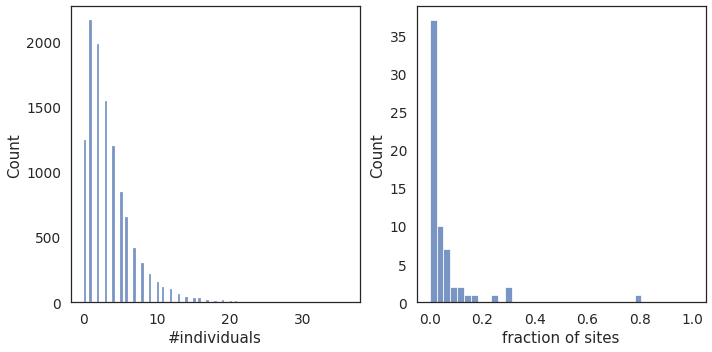

CPU times: user 1.04 s, sys: 1.25 s, total: 2.28 s
Wall time: 612 ms


In [17]:
%%time
fig, axs = plt.subplots( ncols=2, figsize = (10, 5) )


xij = np.array(req_mc_data['xij_losses'])

# sns.histplot( 1 - (np.isnan( xij ).sum(1)/float(xij.shape[1])), ax = axs.flat[0] )
sns.histplot( float(xij.shape[1]) - np.isnan( xij ).sum(1), ax = axs.flat[0] )
axs.flat[0].set_xlabel("#individuals")

# xij = np.array(req_mc_data['xij_gains'])

sns.histplot( 1 - (np.isnan( xij ).sum(0) / float(xij.shape[0])), ax = axs.flat[1] )
axs.flat[1].set_xlim(-0.05, 1.05)
axs.flat[1].set_xlabel("fraction of sites")

fig.tight_layout()
plt.show()


In [18]:
%%time
# fij = req_mc_data['loss_mc_count']
# nij = req_mc_data['loss_mc_total']
# xij = np.array(req_mc_data['xij_losses'])

fij = req_mc_data['gain_mc_count']
nij = req_mc_data['gain_mc_total']
xij = np.array(req_mc_data['xij_gains'])


# filter_ix = (np.where( ((xij.shape[1] - np.isnan( xij ).sum(1)) > 5) & ( fij.sum(1) > 0 ) )[0], np.where((xij.shape[0] - np.isnan( xij ).sum(0)) > 20 )[0] )
filter_ix = (np.where( ((xij.shape[1] - np.isnan( xij ).sum(1)) > 7) )[0], np.where((xij.shape[0] - np.isnan( xij ).sum(0)) > 20 )[0] )
## minimum of 5 individuals with the data on the site and each individual can have minimum of 20 informative sites
print(filter_ix[0].shape)

xij = xij[filter_ix[0],][:,filter_ix[1]]
nij = nij[filter_ix[0],][:,filter_ix[1]]
fij = fij[filter_ix[0],][:,filter_ix[1]]

p_i = np.nanmean(xij, 1)
p_j = np.nanmean(xij, 0)
N = xij.shape[1]
M = xij.shape[0]


sim_fij = pyro.distributions.Binomial(probs=torch.tensor(np.repeat([p_i], N).reshape((M, N)) + p_j), total_count = torch.tensor(nij) ).sample()
sim_xij = bshap.stats.np_get_fraction( sim_fij, nij, y_min=5 )

print("obs", pd.Series(np.nanvar(xij, 1)).describe() )

print("sim", pd.Series(np.nanvar( sim_xij, 1 )).describe() )

(4055,)
obs count    4055.000000
mean        0.001221
std         0.006464
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.162946
dtype: float64
sim count    4055.000000
mean        0.001348
std         0.002609
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002016
max         0.049855
dtype: float64
CPU times: user 513 ms, sys: 316 ms, total: 830 ms
Wall time: 368 ms


In [14]:
np.nanmean(xij, 1).shape

(1814,)

In [12]:
xij.shape

(1814, 36)

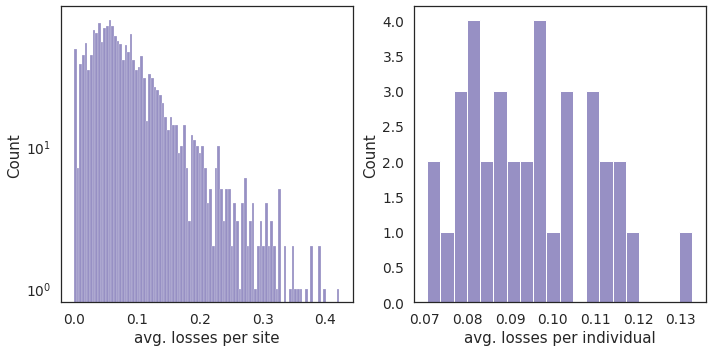

In [16]:
fig, axs = plt.subplots( ncols= 2, figsize = (10, 5) )

sns.histplot( np.nanmean(xij, 1), bins = 100, ax = axs.flat[0], color=cb.sequential.Purples_5.hex_colors[3])
# axs.flat[0].set_ylim(0, 1000)
axs.flat[0].set(yscale = "log")
axs.flat[0].set_xlabel('avg. losses per site')


sns.histplot( np.nanmean(xij, 0), bins = 20, ax = axs.flat[1],color=cb.sequential.Purples_5.hex_colors[3] )
axs.flat[1].set_xlabel('avg. losses per individual')

fig.tight_layout()
# fig.suptitle("losses")
plt.show()

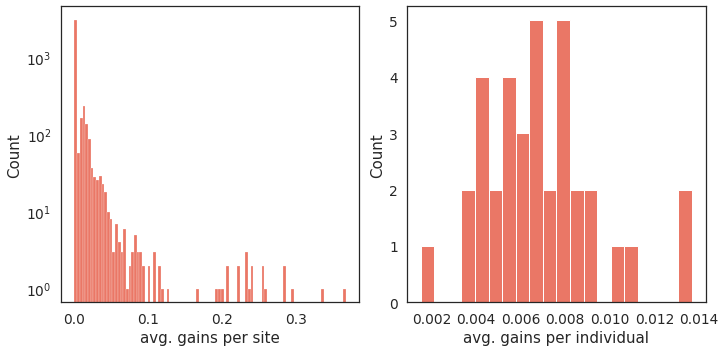

In [19]:
fig, axs = plt.subplots( ncols= 2, figsize = (10, 5) )

sns.histplot( np.nanmean(xij, 1), bins = 100, ax = axs.flat[0], color=cb.sequential.OrRd_5.hex_colors[3] )
# axs.flat[0].set_ylim(0, 1000)
axs.flat[0].set(yscale = "log")
axs.flat[0].set_xlabel('avg. gains per site')


sns.histplot( np.nanmean(xij, 0), bins = 20, ax = axs.flat[1], color=cb.sequential.OrRd_5.hex_colors[3] )
axs.flat[1].set_xlabel('avg. gains per individual')



fig.tight_layout()
# fig.suptitle("gains")
plt.show()

In [11]:
np.nanvar(sim_xij, 1 ).mean()

0.004094848099202435

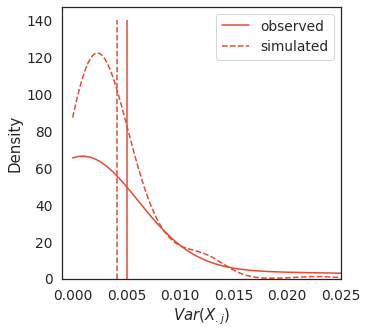

In [34]:
fig, axs = plt.subplots(figsize = (5,5))


sns.kdeplot( np.nanvar(xij, 1),cut = 0, label = 'observed', color = cb.sequential.OrRd_5.hex_colors[3], ax = axs )
axs.vlines(np.nanvar(xij, 1 ).mean(), ymin = 0, ymax = 140, color = cb.sequential.OrRd_5.hex_colors[3], linestyle = '-')
sns.kdeplot( np.nanvar(sim_xij, 1 ), cut = 0, label = 'simulated', color = cb.sequential.OrRd_5.hex_colors[3], ax = axs, linestyle="--")
axs.vlines(np.nanvar(sim_xij, 1 ).mean(), ymin = 0, ymax = 140, color = cb.sequential.OrRd_5.hex_colors[3], linestyle = '--')

# sns.histplot( np.nanvar(xij, 1), label = 'observed', color = cb.sequential.OrRd_5.hex_colors[3], ax = axs )
# sns.histplot( np.nanvar(sim_xij, 1 ), label = 'simulated', color = cb.sequential.OrRd_5.hex_colors[1], ax = axs)

# sns.kdeplot( pyro.distributions.Bernoulli(probs=torch.tensor(p_i)).sample(torch.Size(torch.tensor([xij.shape[1], 5]))).mean(1).var(0), color = "blue")


plt.xlim(-0.001, 0.025)
axs.set_xlabel(r'$ Var( X_{.j} )$')
# plt.ylim(0, 2000)
plt.legend()
plt.show()

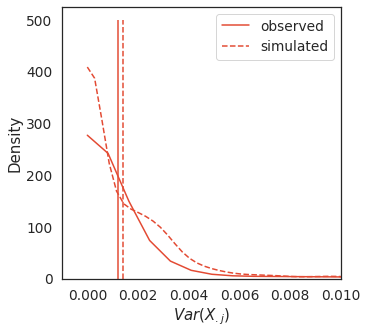

In [38]:
fig, axs = plt.subplots(figsize = (5,5))


sns.kdeplot( np.nanvar(xij, 1),cut = 0, label = 'observed', color = cb.sequential.OrRd_5.hex_colors[3], ax = axs )
axs.vlines(np.nanvar(xij, 1 ).mean(), ymin = 0, ymax = 500, color = cb.sequential.OrRd_5.hex_colors[3], linestyle = '-')
sns.kdeplot( np.nanvar(sim_xij, 1 ), cut = 0, label = 'simulated', color = cb.sequential.OrRd_5.hex_colors[3], ax = axs, linestyle="--")
axs.vlines(np.nanvar(sim_xij, 1 ).mean(), ymin = 0, ymax = 500, color = cb.sequential.OrRd_5.hex_colors[3], linestyle = '--')

# sns.histplot( np.nanvar(xij, 1), label = 'observed', color = cb.sequential.OrRd_5.hex_colors[3], ax = axs )
# sns.histplot( np.nanvar(sim_xij, 1 ), label = 'simulated', color = cb.sequential.OrRd_5.hex_colors[1], ax = axs)

# sns.kdeplot( pyro.distributions.Bernoulli(probs=torch.tensor(p_i)).sample(torch.Size(torch.tensor([xij.shape[1], 5]))).mean(1).var(0), color = "blue")


plt.xlim(-0.001, 0.01)
axs.set_xlabel(r'$ Var( X_{.j} )$')
# plt.ylim(0, 2000)
plt.legend()
plt.show()

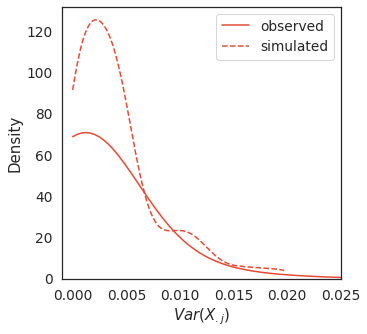

In [163]:
fig, axs = plt.subplots(figsize = (5,5))


sns.kdeplot( np.nanvar(xij, 1),cut = 0, label = 'observed', color = cb.sequential.OrRd_5.hex_colors[3], ax = axs )

# sns.kdeplot( pyro.distributions.Bernoulli(probs=torch.tensor(p_i)).sample(torch.Size(torch.tensor([xij.shape[1], 5]))).mean(1).var(0), color = "blue")
sns.kdeplot( np.nanvar(sim_xij, 1 ), cut = 0, label = 'simulated', color = cb.sequential.OrRd_5.hex_colors[3], ax = axs, linestyle="--")

plt.xlim(-0.001, 0.025)
axs.set_xlabel(r'$ Var( X_{.j} )$')
# plt.ylim(0, 2000)
plt.legend()
plt.show()

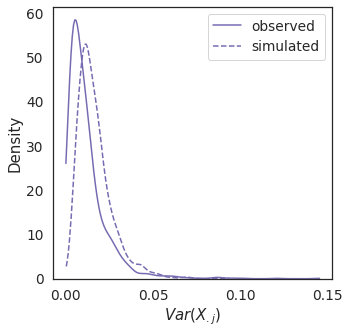

In [48]:
fig, axs = plt.subplots(figsize = (5,5))


sns.kdeplot( np.nanvar(xij, 1), cut = 0, label = 'observed', color = cb.sequential.Purples_5.hex_colors[3], ax = axs )

# sns.kdeplot( pyro.distributions.Bernoulli(probs=torch.tensor(p_i)).sample(torch.Size(torch.tensor([xij.shape[1], 5]))).mean(1).var(0), color = "blue")
sns.kdeplot( np.nanvar( sim_xij, 1 ), cut = 0, label = 'simulated', color = cb.sequential.Purples_5.hex_colors[3], ax = axs, linestyle="--")

# plt.xlim(-0.0001, 0.01)
# plt.ylim(0, 2000)
axs.set_xlabel(r'$ Var( X_{.j} )$')
plt.legend()
plt.show()

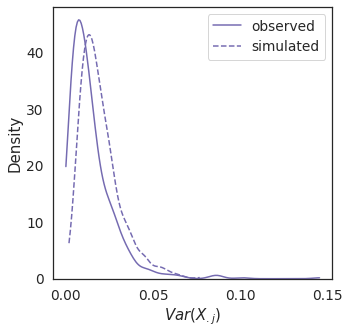

In [44]:
fig, axs = plt.subplots(figsize = (5,5))


sns.kdeplot( np.nanvar(xij, 1), cut = 0, label = 'observed', color = cb.sequential.Purples_5.hex_colors[3], ax = axs )

# sns.kdeplot( pyro.distributions.Bernoulli(probs=torch.tensor(p_i)).sample(torch.Size(torch.tensor([xij.shape[1], 5]))).mean(1).var(0), color = "blue")
sns.kdeplot( np.nanvar( sim_xij, 1 ), cut = 0, label = 'simulated', color = cb.sequential.Purples_5.hex_colors[3], ax = axs, linestyle="--")

# plt.xlim(-0.0001, 0.01)
# plt.ylim(0, 2000)
axs.set_xlabel(r'$ Var( X_{.j} )$')
plt.legend()
plt.show()

### Looking at the actual reads for gains and losses

In [7]:
ef_ix = req_mc_data['mc_data'].sub_pop['AA'][12]


ef_bam = bshap.prebshap.MethylationReads(perc_meths_folder + "/sorted_bam/" + combined_mcs_f2s['meths'].file_ids[ef_ix] + ".sorted.bam", tair10.fasta  )
ef_bed = req_mc_data['mc_bed'].iloc[req_mc_data['loss_pos_ix'],:].loc[:,['chr','start','end']].reset_index(drop = True)
ef_bed['mc_loss'] = pd.Series(req_mc_data['xij_losses'][:,12])
ef_bed = ef_bed.dropna()


[W::hts_idx_load3] The index file is older than the data file: /groups/nordborg/projects//epiclines/005.manu.crosses.2020/004.design_resolved//sorted_bam/T16_P4.C5_F2_D1.sorted.bam.bai


In [8]:
ef_read_data = pd.DataFrame()
for ef_pos in ef_bed.iterrows():
    t_reads = ef_bam.scan_region( ef_pos[1]['chr'] + ',' + str(ef_pos[1]['start']) + ',' + str(ef_pos[1]['end']) )
    t_reads['idx'] = ef_pos[0]
    t_reads['mc_loss'] = ef_pos[1]['mc_loss']
    ef_read_data = pd.concat([ef_read_data,t_reads ])
    
ef_read_data = ef_read_data.reset_index(drop = True)

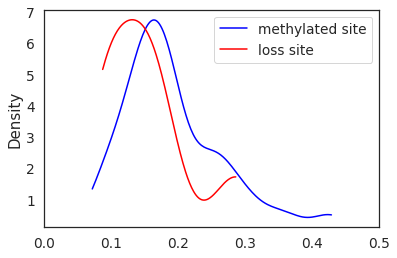

In [26]:
# sns.kdeplot( x = ef_read_data.loc[ef_read_data['mc_loss'] < 0.05, 'permeth'].values, color = "blue", label = "methylated site", cut =0)
# sns.kdeplot( x = ef_read_data.loc[ef_read_data['mc_loss'] > 0.3, 'permeth'].values, color = "red", label = "loss site",cut = 0)


sns.kdeplot( x = ef_read_data.loc[(ef_read_data['mc_loss'] < 0.05) & (ef_read_data['mc_count'] > 1), 'permeth'].values, color = "blue", label = "methylated site", cut =0)
sns.kdeplot( x = ef_read_data.loc[(ef_read_data['mc_loss'] > 0.3) & (ef_read_data['mc_count'] > 1), 'permeth'].values, color = "red", label = "loss site",cut = 0)


# sns.histplot( x = ef_read_data.loc[ef_read_data['mc_loss'] < 0.05, 'permeth'].values, color = "blue", label = "methylated site", binrange=(0,0.5), binwidth=0.01, alpha = 0.2)
# sns.histplot( x = ef_read_data.loc[ef_read_data['mc_loss'] > 0.3, 'permeth'].values, color = "red", label = "lost site",binrange=(0,0.5), binwidth=0.01, alpha = 0.6)


plt.xlim(0, 0.5)
plt.legend()

In [27]:
ef_ix = req_mc_data['mc_data'].sub_pop['AA'][10]


ef_bam = bshap.prebshap.MethylationReads(perc_meths_folder + "/sorted_bam/" + combined_mcs_f2s['meths'].file_ids[ef_ix] + ".sorted.bam", tair10.fasta  )
ef_bed = req_mc_data['mc_bed'].iloc[req_mc_data['gain_pos_ix'],:].loc[:,['chr','start','end']].reset_index(drop = True)
ef_bed['mc_gain'] = pd.Series(req_mc_data['xij_gains'][:,10])
ef_bed = ef_bed.dropna()


[W::hts_idx_load3] The index file is older than the data file: /groups/nordborg/projects//epiclines/005.manu.crosses.2020/004.design_resolved//sorted_bam/T16_P4.A4_F2_D1.sorted.bam.bai


In [28]:
ef_read_data = pd.DataFrame()
for ef_pos in ef_bed.iterrows():
    t_reads = ef_bam.scan_region( ef_pos[1]['chr'] + ',' + str(ef_pos[1]['start']) + ',' + str(ef_pos[1]['end']) )
    t_reads['idx'] = ef_pos[0]
    t_reads['mc_gain'] = ef_pos[1]['mc_gain']
    ef_read_data = pd.concat([ef_read_data,t_reads ])
    
ef_read_data = ef_read_data.reset_index(drop = True)

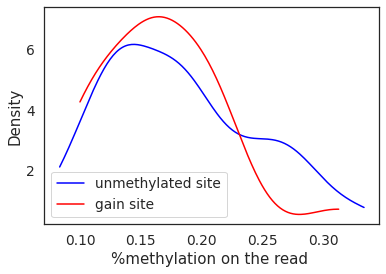

In [31]:
# sns.kdeplot( x = ef_read_data.loc[ef_read_data['mc_gain'] < 0.05, 'permeth'].values, color = "blue", label = "unmethylated site", cut =0)
# sns.kdeplot( x = ef_read_data.loc[ef_read_data['mc_gain'] > 0.1, 'permeth'].values, color = "red", label = "gain site",cut = 0)


sns.kdeplot( x = ef_read_data.loc[(ef_read_data['mc_gain'] < 0.05) & (ef_read_data['mc_count'] > 1), 'permeth'].values, color = "blue", label = "unmethylated site", cut =0)
sns.kdeplot( x = ef_read_data.loc[(ef_read_data['mc_gain'] > 0.15) & (ef_read_data['mc_count'] > 1), 'permeth'].values, color = "red", label = "gain site",cut = 0)





# sns.histplot( x = ef_read_data.loc[ef_read_data['mc_gain'] < 0.05, 'permeth'].values, color = "blue", label = "methylated site", binrange=(0,0.5), binwidth=0.01, alpha = 0.2)
# sns.histplot( x = ef_read_data.loc[ef_read_data['mc_gain'] > 0.1, 'permeth'].values, color = "red", label = "gain site",binrange=(0,0.5), binwidth=0.01, alpha = 0.6)

plt.xlabel("%methylation on the read ")
plt.legend()

In [68]:
readdata = m.scan_region("ChrC,32000,33000", sample_reads=10000)
readdata_pe = readdata.loc[:,['read_id', 'mc_total', 'mc_count']].groupby("read_id").sum()
readdata_pe['permeth'] = bshap.stats.np_get_fraction(readdata_pe['mc_count'].values, readdata_pe['mc_total'].values, y_min=5)

In [180]:
xij = req_mc_data['xij_losses']
p_i = np.nanmean(xij, 1)

In [150]:
np.mean(np.nanvar(xij, 1))

0.012045280406516607

In [151]:
np.mean(np.nanvar(sim_xij, 1))

0.016455678996350823

In [182]:
pyro.distributions.Bernoulli(probs=torch.tensor(p_i)).sample(torch.Size(torch.tensor([xij.shape[1], 5]))).mean(1).var(0).mean()

tensor(0.0151, dtype=torch.float64)

In [159]:
xij = req_mc_data['xij_losses']
p_i = np.nanmean(xij, 1)

In [160]:
p_i = np.nanmean( np.nanmean(xij, 1) )
print(p_i)
N = np.nanmean(xij, 0).shape[0]

(p_i * ( 1 - p_i ))/N

0.08996899891523144


/tmp/ipykernel_41644/919095054.py:3: RuntimeWarning: Mean of empty slice
  N = np.nanmean(xij, 0).shape[0]


0.0012792902835847269

In [161]:
np.nanvar( np.nanmean(xij, 1) )

0.0060743946239740975

In [29]:
cov_x = ma.cov(ma.masked_invalid(xij.T))
cov_x = np.tril(cov_x, -1 ).flatten() 
cov_x = cov_x[cov_x != 0 ]

In [33]:
np.nanvar(xij, 1)

array([0., 0., 0., ..., 0., 0., 0.])

# Calculating epimutataion gains/losses

Assumptions: 
Cytosine gets either 0 or 1 methylation state through zygote.


In [66]:
%%time

req_mc_data = {}
# req_mc_data['bed_str'] = "Chr3,1,500000"
# req_mc_data['bed_str'] = "Chr1,20000001,22000000"
# req_mc_data['bed_str'] = "Chr3,3000001,4000000"
# req_mc_data['bed_str'] = "Chr5,3000001,3500001"
req_mc_data['bed_str'] = "Chr4,5000001,6000000"



req_mc_data['samples'] = pyquant.parsers.split_ids( plate_design.loc[ combined_mcs_f2s['meths'].file_ids.values, 'replicated_id'] ).reset_index().set_index( combined_mcs_f2s['meths'].file_ids.values )
req_mc_data['replicated_ids'] = req_mc_data['samples'].loc[ req_mc_data['samples'].index.str.startswith("mix"), 'replicated_id' ]
req_mc_data['replicated_ids'] = req_mc_data['replicated_ids'].reset_index().set_axis(['rep2', 'rep1'], axis=1, inplace=False)
# req_mc_data['replicated_ids'] = pd.melt(req_mc_data['replicated_ids'], var_name= "rep", value_name = 'id' ).set_index( "id" )

req_mc_data['geno_groups'] = cross_data.get_genotype_dict_at_bed_str("d1_2020", req_mc_data['bed_str'])[1].reindex( req_mc_data['samples'].index ).reset_index().groupby("geno").groups
# req_mc_data['geno_groups'] = cross_data.get_genotype_dict_at_bed_str("d1_2020", req_mc_data['bed_str'])[1].reindex( req_mc_data['samples']['replicated_id'] ).reset_index().groupby("geno").groups




req_mc_data['mcg_nuclear_ix'] = combined_mcs_f2s['meths'].get_req_pos_bed_str(req_mc_data['bed_str'], req_mc_class = "CG[ATCG]", exon_bed_df=tair10.gene_exon )

req_mc_data['cg_count'] = combined_mcs_f2s['meths'].__getattr__("mc_count", req_mc_data['mcg_nuclear_ix'])
req_mc_data['cg_total'] = combined_mcs_f2s['meths'].__getattr__("mc_total", req_mc_data['mcg_nuclear_ix'])


CPU times: user 5.18 s, sys: 3.8 s, total: 8.98 s
Wall time: 9.51 s


In [67]:
%%time
req_mc_data['mcs_chrc_bed'] = combined_mcs_f2s['meths'].get_req_pos_bed_str("ChrC,1,152000", req_mc_class = "CG[ATCG]", exon_bed_df = None)

req_mc_data['samples']['depth_chr1'] = req_mc_data['cg_total'].mean(0)

req_mc_data['chrc_mc_total'] = combined_mcs_f2s['meths'].__getattr__( "mc_total", req_mc_data['mcs_chrc_bed'] )
req_mc_data['chrc_mc_count'] = combined_mcs_f2s['meths'].__getattr__( "mc_count", req_mc_data['mcs_chrc_bed'] )


req_mc_data['samples']['depth_chrc'] = np.mean(req_mc_data['chrc_mc_total'], 0)
req_mc_data['samples']['cnv_chrc'] = req_mc_data['samples']['depth_chrc'] / req_mc_data['samples']['depth_chr1']

req_pos_ix = np.sort(np.random.choice(len(req_mc_data['mcs_chrc_bed']), 1000, replace=False))
# req_pos_ix = np.arange(len(req_mc_data['mcs_chrc_bed']))

req_mc_data['samples']['cobs_chrc'] = bshap.combinemeths.np_get_fraction(req_mc_data['chrc_mc_count'][req_pos_ix,:].sum(0), req_mc_data['chrc_mc_total'][req_pos_ix,:].sum(0))

CPU times: user 1.49 s, sys: 1.1 s, total: 2.59 s
Wall time: 2.59 s


## Method 1

Infer the methylation status for the parent from the homozygous individuals

In [78]:
%%time
ef_devs = bshap.combinemeths.calculate_deviations_f2_populations(req_mc_data['cg_count'], req_mc_data['cg_total'], req_mc_data['geno_groups'], params_meths = {
    "max_meth_for_gain" : 0.5,
    "min_meth_for_loss" : 0.5,
    "mc_total_min" : 3,
    "prop_y_min" : 20,
    "conv_rate": 0.03
})
ef_devs['deviations'].index = combined_mcs_f2s['meths'].file_ids[ef_devs['deviations'].index].values
req_mc_data['deviations'] = pd.merge(req_mc_data['samples'], ef_devs['deviations'], left_index=True, right_index=True)

CPU times: user 418 ms, sys: 24.4 ms, total: 442 ms
Wall time: 440 ms


AA vs. AB: Mann-Whitney-Wilcoxon test two-sided, P_val:6.886e-15 U_stat=8.398e+03
AB vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:2.479e-08 U_stat=2.209e+03
AA vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:7.687e-03 U_stat=2.750e+03
AA vs. AB: Mann-Whitney-Wilcoxon test two-sided, P_val:1.338e-04 U_stat=6.706e+03
AB vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:3.695e-10 U_stat=1.942e+03
AA vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:2.128e-03 U_stat=1.492e+03


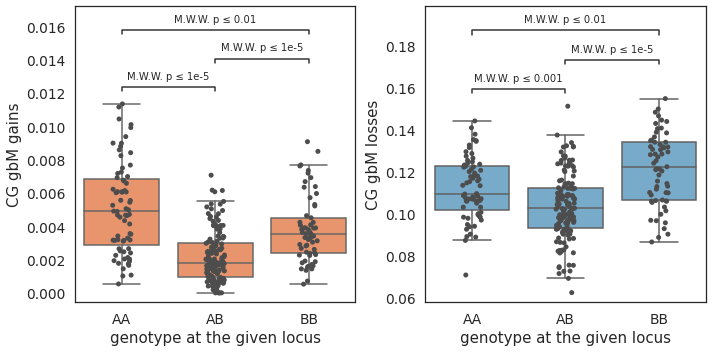

In [79]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":6
}


fig, axs = plt.subplots(ncols = 2, figsize = (10, 5))

fig_args = {
    "data": req_mc_data['deviations'], 
    "y": "deviation_0",
    "x": "subpop",
    "dodge": True,
    "order": ['AA', 'AB', 'BB'],
    "ax": axs.flat[0]
}
sns.stripplot(**fig_args, jitter=True, palette=['.3'] * 3 )
sns.boxplot( **fig_args, color = cb.sequential.OrRd_5.hex_colors[2], fliersize=0)

fig_args['ax'].set_ylabel("CG gbM gains")
fig_args['ax'].set_xlabel("genotype at the given locus")
# axs.flat[0].set_ylim(0, 0.006)

annotator = Annotator.Annotator(**fig_args, pairs = [ ('AA', 'BB'), ('AA', 'AB'), ('AB', 'BB') ], plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()


fig_args = {
    "data": req_mc_data['deviations'], 
    "y": "deviation_1",
    "x": "subpop",
    "dodge": True,
    "order": ['AA', 'AB', 'BB'],
    "ax": axs.flat[1]
}
sns.stripplot(**fig_args, jitter=True, palette=['.3'] * 3 )
sns.boxplot( **fig_args, color = cb.sequential.Blues_5.hex_colors[2], fliersize=0)

fig_args['ax'].set_ylabel("CG gbM losses")
fig_args['ax'].set_xlabel("genotype at the given locus")
# axs.flat[0].set_ylim(0, 0.006)

annotator = Annotator.Annotator(**fig_args, pairs = [ ('AA', 'BB'), ('AA', 'AB'), ('AB', 'BB') ], plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()





fig.tight_layout()

## Method 2

Infer the methylation status for a given genotype within its population.

In [76]:
%%time
ef_devs = bshap.combinemeths.calculate_deviations_per_populations(req_mc_data['cg_count'], req_mc_data['cg_total'], req_mc_data['geno_groups'], params_meths = {
    "max_meth_for_gain" : 0.3,
    "min_meth_for_loss" : 0.6,
    "mc_total_min" : 3,
    "prop_y_min" : 20,
    "conv_rate": 0.03
})
ef_devs['deviations'].index = combined_mcs_f2s['meths'].file_ids[ef_devs['deviations'].index].values
req_mc_data['deviations'] = pd.merge(req_mc_data['samples'], ef_devs['deviations'], left_index=True, right_index=True)

CPU times: user 440 ms, sys: 100 ms, total: 540 ms
Wall time: 538 ms


AA vs. AB: Mann-Whitney-Wilcoxon test two-sided, P_val:4.760e-01 U_stat=5.381e+03
AB vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:1.554e-01 U_stat=4.910e+03
AA vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:5.296e-02 U_stat=2.590e+03
AA vs. AB: Mann-Whitney-Wilcoxon test two-sided, P_val:6.487e-03 U_stat=3.915e+03
AB vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:2.354e-01 U_stat=3.903e+03
AA vs. BB: Mann-Whitney-Wilcoxon test two-sided, P_val:1.911e-03 U_stat=1.485e+03


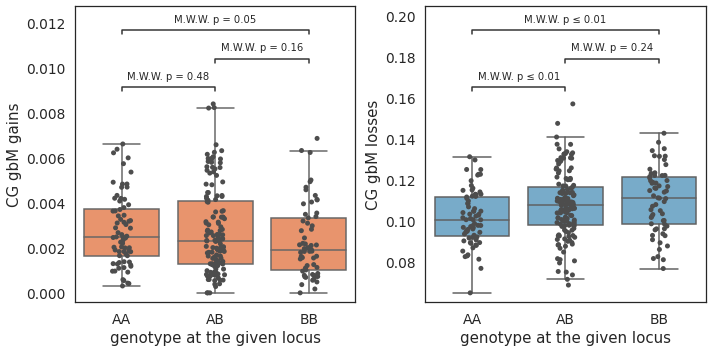

In [77]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":6
}


fig, axs = plt.subplots(ncols = 2, figsize = (10, 5))

fig_args = {
    "data": req_mc_data['deviations'], 
    "y": "deviation_0",
    "x": "subpop",
    "dodge": True,
    "order": ['AA', 'AB', 'BB'],
    "ax": axs.flat[0]
}
sns.stripplot(**fig_args, jitter=True, palette=['.3'] * 3 )
sns.boxplot( **fig_args, color = cb.sequential.OrRd_5.hex_colors[2], fliersize=0)

fig_args['ax'].set_ylabel("CG gbM gains")
fig_args['ax'].set_xlabel("genotype at the given locus")
# axs.flat[0].set_ylim(0, 0.006)

annotator = Annotator.Annotator(**fig_args, pairs = [ ('AA', 'BB'), ('AA', 'AB'), ('AB', 'BB') ], plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()


fig_args = {
    "data": req_mc_data['deviations'], 
    "y": "deviation_1",
    "x": "subpop",
    "dodge": True,
    "order": ['AA', 'AB', 'BB'],
    "ax": axs.flat[1]
}
sns.stripplot(**fig_args, jitter=True, palette=['.3'] * 3 )
sns.boxplot( **fig_args, color = cb.sequential.Blues_5.hex_colors[2], fliersize=0)

fig_args['ax'].set_ylabel("CG gbM losses")
fig_args['ax'].set_xlabel("genotype at the given locus")
# axs.flat[0].set_ylim(0, 0.006)

annotator = Annotator.Annotator(**fig_args, pairs = [ ('AA', 'BB'), ('AA', 'AB'), ('AB', 'BB') ], plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()





fig.tight_layout()

# Do AA gain or BB loose more when you leave it for `n` generations. 


We have a gain `a` and loss `b` rates in somatic tissue. Consider a fraction of this `alpha` that end up in the next generation. 


consider there are `n` number of sites of which `n x m` are methylated. What is the expected `m` after say `t` generations. 

In [6]:
from scipy.integrate import odeint



class EpiComposition(object):
    ## model compartments
    labels = ['methylated', 'unmethylated']
    default_params = {
        'soma_gain': 0.005,
        'soma_loss': 0.08,
        'alpha':0.001,
        'beta':0.001,
        'n': 10000,
        'm': 0.1
    }
    
    def __init__(self, params, t = None):
        self.params = self.default_params.copy()
        self.params.update(params)    
        self.params['a'] = self.params['soma_gain'] * self.params['alpha']
        self.params['b'] = self.params['soma_loss'] * self.params['beta']
        self.y0 = [ self.params['m'], (1 - self.params['m'])  ]
        if t is not None:
            self.t = t
            self.result = self.solve_for_t(self.t)
    
    @staticmethod
    def model(y0, t, a, b):
        y = np.dot(y0, np.linalg.matrix_power(np.array( [[1 - b, b], [a, 1 - a] ] ), t))
        return(y)

    def solve_for_t(self, t):
        assert type(t) is np.ndarray, "provide a numpy array for times"
        data = np.array([])
        for ef_t in t:
            data = np.append(data, self.model(self.y0, ef_t, self.params['a'], self.params['b'])[0] )
        return(data)


In [8]:
mc_data = pd.read_csv("cache_data/epimutation_rates_500Kb_rep2_boxcox_var_decomp_lme.csv", index_col=0)
mc_data = mc_data.loc[:,mc_data.columns.str.contains("pred_")]

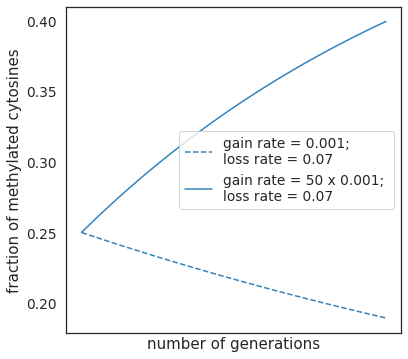

In [9]:
t = np.linspace(1, 10000, 100).astype(int)


fig, axs = plt.subplots(figsize = (6,6))

epi = EpiComposition({'m': 0.25,'alpha': 0.02, 'beta': 0.0005,'soma_gain': 0.0001, 'soma_loss':  0.07}, t = t )
sns.lineplot(x = epi.t, y = epi.result, ax=axs, color = cb.sequential.Blues_6.hex_colors[4], ls= '--', label = "gain rate = 0.001; \nloss rate = 0.07" )

epi = EpiComposition({'m': 0.25,'alpha': 0.02, 'beta': 0.0005,'soma_gain': 0.0001 * 20, 'soma_loss':  0.07},t = t)
sns.lineplot(x = epi.t, y = epi.result, ax=axs, color = cb.sequential.Blues_6.hex_colors[4], ls= '-', label = "gain rate = 50 x 0.001; \nloss rate = 0.07"  )

axs.set_ylabel("fraction of methylated cytosines")
axs.set_xlabel("number of generations")
axs.set_xticks([])
plt.legend()
plt.show()



In [ ]:
mc_data.describe(percentiles=ci_ints.values.tolist())

,gain_pred_AA_T4,gain_pred_AA_T16,gain_pred_BB_T4,gain_pred_BB_T16,loss_pred_AA_T4,loss_pred_AA_T16,loss_pred_BB_T4,loss_pred_BB_T16
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,0.186884,0.200642,0.126898,-0.051980,-0.131537,-0.095500,-0.087551,-0.042591
std,0.195121,0.196437,0.217748,0.178113,0.163076,0.150930,0.164896,0.149924
min,-0.514675,-0.303302,-0.451576,-0.505727,-0.586510,-0.685295,-0.714814,-0.537191
40%,0.132343,0.153592,0.048124,-0.093108,-0.169308,-0.128411,-0.126518,-0.082114
50%,0.183902,0.194141,0.083760,-0.043979,-0.118534,-0.090548,-0.084529,-0.045245
60%,0.233556,0.234806,0.154201,-0.005651,-0.076248,-0.053339,-0.049916,-0.005728
max,0.691330,0.742719,1.371919,0.599362,0.384001,0.289895,0.553773,0.437958


[0.19414118 0.1839018 ]
[-0.04397874  0.08375997]
[-0.09054836 -0.11853433]
[-0.04524475 -0.08452901]


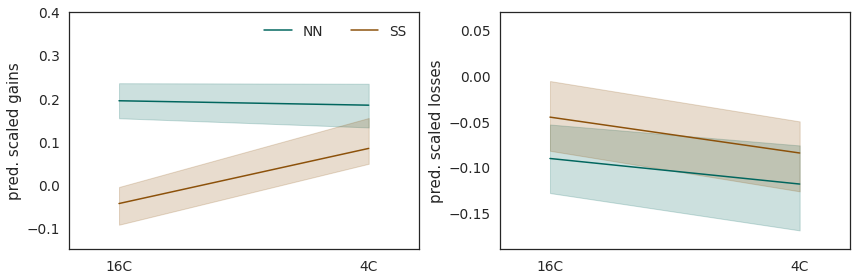

In [28]:
ci_ints = pd.Series( [0.4, 0.5, 0.6], index = ["40%", "50%", "60%"] )
ef_data = mc_data.describe(percentiles=ci_ints.values.tolist())


fig, axs = plt.subplots(ncols=2, figsize = (12, 4))


ax = axs.flat[0]
ax.plot( (0, 1), ef_data.loc[ci_ints.index[1], ['gain_pred_AA_T16', 'gain_pred_AA_T4']].values, '-', color = cb.diverging.BrBG_7.hex_colors[6], label = "NN")
ax.fill_between( [0, 1], ef_data.loc[ci_ints.index[0], ['gain_pred_AA_T16', 'gain_pred_AA_T4']].values, ef_data.loc[ci_ints.index[2], ['gain_pred_AA_T16', 'gain_pred_AA_T4']].values, color = cb.diverging.BrBG_7.hex_colors[6], alpha = 0.2, interpolate = True )

ax.plot( (0, 1), ef_data.loc[ci_ints.index[1], ['gain_pred_BB_T16', 'gain_pred_BB_T4']].values, '-', color = cb.diverging.BrBG_7.hex_colors[0], label = "SS")
ax.fill_between( [0, 1], ef_data.loc[ci_ints.index[0], ['gain_pred_BB_T16', 'gain_pred_BB_T4']].values, ef_data.loc[ci_ints.index[2], ['gain_pred_BB_T16', 'gain_pred_BB_T4']].values, color = cb.diverging.BrBG_7.hex_colors[0], alpha = 0.2, interpolate = True )

print( ef_data.loc[ci_ints.index[1], ['gain_pred_AA_T16', 'gain_pred_AA_T4']].values )
print( ef_data.loc[ci_ints.index[1], ['gain_pred_BB_T16', 'gain_pred_BB_T4']].values )
ax.legend(frameon = False, ncol =2)
ax.set_xlim((-0.2, 1.2))
# ax.set_ylim((0.0003, 0.00171))
ax.set_ylim((-0.15, 0.4))
ax.set_xticks([0, 1])
ax.set_xticklabels(["16C", "4C"])
ax.set_ylabel( "pred. scaled gains" )




ax = axs.flat[1]
ax.plot( (0, 1), ef_data.loc[ci_ints.index[1], ['loss_pred_AA_T16', 'loss_pred_AA_T4']].values, '-', color = cb.diverging.BrBG_7.hex_colors[6])
ax.fill_between( [0, 1], ef_data.loc[ci_ints.index[0], ['loss_pred_AA_T16', 'loss_pred_AA_T4']].values, ef_data.loc[ci_ints.index[2], ['loss_pred_AA_T16', 'loss_pred_AA_T4']].values, color = cb.diverging.BrBG_7.hex_colors[6], alpha = 0.2, interpolate = True )

ax.plot( (0, 1), ef_data.loc[ci_ints.index[1], ['loss_pred_BB_T16', 'loss_pred_BB_T4']].values, '-', color = cb.diverging.BrBG_7.hex_colors[0])
ax.fill_between( [0, 1], ef_data.loc[ci_ints.index[0], ['loss_pred_BB_T16', 'loss_pred_BB_T4']].values, ef_data.loc[ci_ints.index[2], ['loss_pred_BB_T16', 'loss_pred_BB_T4']].values, color = cb.diverging.BrBG_7.hex_colors[0], alpha = 0.2, interpolate = True )
print( ef_data.loc[ci_ints.index[1], ['loss_pred_AA_T16', 'loss_pred_AA_T4']].values )
print( ef_data.loc[ci_ints.index[1], ['loss_pred_BB_T16', 'loss_pred_BB_T4']].values )

ax.set_xlim((-0.2, 1.2))
# ax.set_ylim((0.061, 0.081))
ax.set_ylim((-0.19, 0.07))
ax.set_xticks([0, 1])
ax.set_xticklabels(['16C', "4C"])
ax.set_ylabel( "pred. scaled losses" )
# ax.legend()


fig.tight_layout()

plt.savefig("epimutations_gxe.pdf",bbox_inches='tight')

[0.00119843 0.00101673]
[0.00068209 0.00142082]
[0.06955697 0.06936189]
[0.07516185 0.07392705]


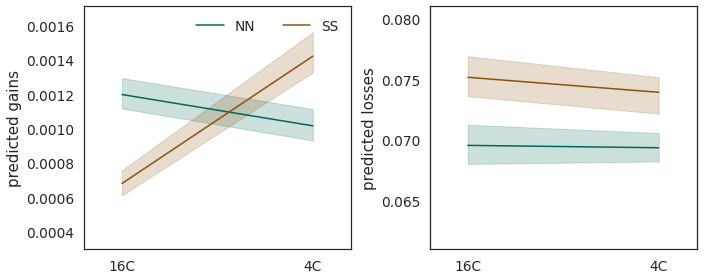

In [14]:
ci_ints = pd.Series( [0.4, 0.5, 0.6], index = ["40%", "50%", "60%"] )
ef_data = mc_data.describe(percentiles=ci_ints.values.tolist())


fig, axs = plt.subplots(ncols=2, figsize = (10, 4))


ax = axs.flat[0]
ax.plot( (0, 1), ef_data.loc[ci_ints.index[1], ['pred_AA_gain_T16', 'pred_AA_gain_T4']].values, '-', color = cb.diverging.BrBG_7.hex_colors[6], label = "NN")
ax.fill_between( [0, 1], ef_data.loc[ci_ints.index[0], ['pred_AA_gain_T16', 'pred_AA_gain_T4']].values, ef_data.loc[ci_ints.index[2], ['pred_AA_gain_T16', 'pred_AA_gain_T4']].values, color = cb.diverging.BrBG_7.hex_colors[6], alpha = 0.2, interpolate = True )

ax.plot( (0, 1), ef_data.loc[ci_ints.index[1], ['pred_BB_gain_T16', 'pred_BB_gain_T4']].values, '-', color = cb.diverging.BrBG_7.hex_colors[0], label = "SS")
ax.fill_between( [0, 1], ef_data.loc[ci_ints.index[0], ['pred_BB_gain_T16', 'pred_BB_gain_T4']].values, ef_data.loc[ci_ints.index[2], ['pred_BB_gain_T16', 'pred_BB_gain_T4']].values, color = cb.diverging.BrBG_7.hex_colors[0], alpha = 0.2, interpolate = True )

print( ef_data.loc[ci_ints.index[1], ['pred_AA_gain_T16', 'pred_AA_gain_T4']].values )
print( ef_data.loc[ci_ints.index[1], ['pred_BB_gain_T16', 'pred_BB_gain_T4']].values )
ax.legend(frameon = False, ncol =2)
ax.set_xlim((-0.2, 1.2))
ax.set_ylim((0.0003, 0.00171))
ax.set_xticks([0, 1])
ax.set_xticklabels(["16C", "4C"])
ax.set_ylabel( "predicted gains" )




ax = axs.flat[1]
ax.plot( (0, 1), ef_data.loc[ci_ints.index[1], ['pred_AA_loss_T16', 'pred_AA_loss_T4']].values, '-', color = cb.diverging.BrBG_7.hex_colors[6])
ax.fill_between( [0, 1], ef_data.loc[ci_ints.index[0], ['pred_AA_loss_T16', 'pred_AA_loss_T4']].values, ef_data.loc[ci_ints.index[2], ['pred_AA_loss_T16', 'pred_AA_loss_T4']].values, color = cb.diverging.BrBG_7.hex_colors[6], alpha = 0.2, interpolate = True )

ax.plot( (0, 1), ef_data.loc[ci_ints.index[1], ['pred_BB_loss_T16', 'pred_BB_loss_T4']].values, '-', color = cb.diverging.BrBG_7.hex_colors[0])
ax.fill_between( [0, 1], ef_data.loc[ci_ints.index[0], ['pred_BB_loss_T16', 'pred_BB_loss_T4']].values, ef_data.loc[ci_ints.index[2], ['pred_BB_loss_T16', 'pred_BB_loss_T4']].values, color = cb.diverging.BrBG_7.hex_colors[0], alpha = 0.2, interpolate = True )
print( ef_data.loc[ci_ints.index[1], ['pred_AA_loss_T16', 'pred_AA_loss_T4']].values )
print( ef_data.loc[ci_ints.index[1], ['pred_BB_loss_T16', 'pred_BB_loss_T4']].values )

ax.set_xlim((-0.2, 1.2))
ax.set_ylim((0.061, 0.081))
ax.set_xticks([0, 1])
ax.set_xticklabels(['16C', "4C"])
ax.set_ylabel( "predicted losses" )
# ax.legend()


fig.tight_layout()

plt.savefig("epimutations_gxe.pdf",bbox_inches='tight')

In [19]:

print( (0.07392705 - 0.06936189) / 0.07392705 )

print( (0.07516185 - 0.06955697) / 0.07516185 )

0.061752227364679085
0.0745708095263755


In [18]:
((0.07516185+0.07392705) - (0.06955697+0.06936189))/(0.07516185+0.07392705)

0.06821460216018778

In [17]:
### Assume that current fraction of methylation on AA is at equilibrium

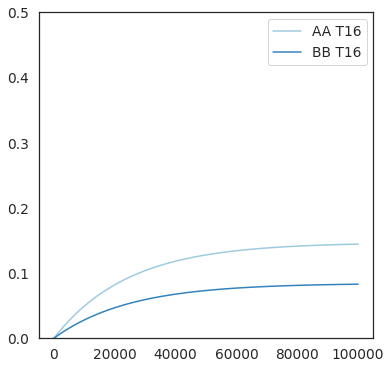

In [39]:
t = np.linspace(1, 100000, 100).astype(int)


fig, axs = plt.subplots(figsize = (6,6))

epi = EpiComposition({'m': 0,'alpha': 0.005, 'beta': 0.0005,'soma_gain': 0.001198, 'soma_loss': 0.069557}, t = t )
sns.lineplot(x = epi.t, y = epi.result, ax=axs, color = cb.sequential.Blues_6.hex_colors[2], label = "AA T16" )

epi = EpiComposition({'m': 0,'alpha': 0.005, 'beta': 0.0005,'soma_gain': 0.000682, 'soma_loss':0.073927},t = t)
sns.lineplot(x = epi.t, y = epi.result, ax=axs, color = cb.sequential.Blues_6.hex_colors[4], label = "BB T16" )

axs.set_ylim(0, 0.5)

plt.legend()
plt.show()

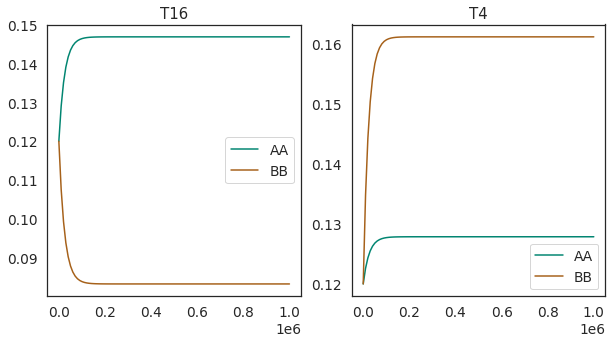

In [43]:
params = {
    "m": 0.12, 'alpha': 0.005, 'beta': 0.0005
}
t = np.linspace(1, 1000000, 100).astype(int)


fig, axs = plt.subplots(ncols = 2, figsize = (10,5))

epi = EpiComposition({**params,'soma_gain': 0.001198, 'soma_loss': 0.069557},t = t)
sns.lineplot(x = epi.t, y = epi.result, ax=axs.flat[0], color = cb.diverging.BrBG_5.hex_colors[4], label = "AA" )

epi = EpiComposition({**params,'soma_gain': 0.000682, 'soma_loss': 0.075162}, t = t )
sns.lineplot(x = epi.t, y = epi.result, ax=axs.flat[0], color = cb.diverging.BrBG_5.hex_colors[0], label = "BB" )
axs.flat[0].set_title("T16")



epi = EpiComposition({**params,'soma_gain': 0.001017, 'soma_loss': 0.069362},t = t)
sns.lineplot(x = epi.t, y = epi.result, ax=axs.flat[1], color = cb.diverging.BrBG_5.hex_colors[4], label = "AA" )

epi = EpiComposition({**params,'soma_gain': 0.001421, 'soma_loss': 0.073927}, t = t )
sns.lineplot(x = epi.t, y = epi.result, ax=axs.flat[1], color = cb.diverging.BrBG_5.hex_colors[0], label = "BB" )
axs.flat[1].set_title("T4")

plt.legend()
plt.show()
